** Link para vídeo de utilização**:
https://youtu.be/3S2G-VvU4AY

# Configurações

### Imports de Pacotes

In [ ]:
# Instalação de pacotes adicionais
%pip install ibm_watson
%pip install azure-cognitiveservices-vision-face

In [ ]:
# Pacotes para tratamento da imagem
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode

# Pacotes para uso da API do Watson Visual Recognition
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# Pacotes para uso da API do AzureML
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials

# pacotes adicionais de trabalho
import time
import json
import os
from PIL import Image, ImageDraw
import pandas as pd

# Pacotes para import requests
import requests

### Definição de Funções úteis

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def drawCrossesOnFace(faceLandmarks, size=2, color='white'):
    fl = faceLandmarks.as_dict()
    for l in fl.keys():
        x = fl[l]['x']
        y = fl[l]['y']
        draw.line(((x - size, y - size), (x + size, y + size)), fill=color)
        draw.line(((x - size, y + size), (x + size, y - size)), fill=color)
    pass

### Autenticações nas Plataformas


##### Watson

In [ ]:
# Cria chave de autent
auth_ibm = 'auth_data/mykey_IBM.json'
if os.path.exists(auth_ibm):
    with open(auth_ibm) as json_file:
        mykey = json.load(json_file)

# Instancia Objeto para Autenticação da IBM
authenticator = IAMAuthenticator(mykey["key"])

# Instancia Objeto para Reconhecimento Visual IBM
visual_recognition = VisualRecognitionV3(version='2018-03-19',
                                         authenticator=authenticator)

# Configura ponto de acesso do objeto
visual_recognition.set_service_url(mykey["url"])

##### Azure

In [ ]:
# autentica e instancia o cliente
with open("./auth_data/azurekeys.json", 'r') as jsonfile:
  azurekeys = json.load(jsonfile)
KEY = azurekeys["FacialDetection"]["KEY"] #Coloque aqui sua chave
ENDPOINT = azurekeys["FacialDetection"]["ENDPOINT"]  #Coloque aqui seu endpoint (Ponto de Extremidade)
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))  

##### Google Cloud Platform

In [ ]:
my_server_ip = "34.121.22.232"
my_server_port = "443"
url = "http://{}:{}/predict".format(my_server_ip, my_server_port)
headers = {'Content-Type': 'application/json'}

## Preenche Informações do cliente

In [ ]:
#@title Preencha aqui com as informações do cliente requisitante

#@markdown Informe todos os campos a seguir:
nome = "Marcelo Costa" #@param {type:"string"}

renda = 10000.00 #@param {type:"number"}
idade = 37 #@param {type:"slider", min:18, max:100, step:1}
etnia = "Etnia02"  #@param ["Selecionar etnia", "Etnia01", "Etnia02"]
genero = "Masculino" #@param ["Masculino", "Feminino"]
casa_propria = "Nao" #@param ["Sim", "Nao"]
outras_rendas = "Nao" #@param ["Sim", "Nao"]
estado_civil = "Estado02" #@param ["Estado01", "Estado02"]
escolaridade = 3 #@param {type:"slider", min:0, max:3, step:1}

#@markdown ---

id_chamada = 0

In [ ]:
#@title Tire uma foto do cliente requerente (ou tire uma foto sua mesmo)

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

id_chamada += 1

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable


## Realiza Análise de crédito

### Validações de Foto - IBM Watson

In [ ]:
# define tipo de classificador desejado a ser utilizado
classifier_id = 'default'

# Chama a API do Watson e salva retorno em um dicionário classes_default
with open('./photo.jpg', 'rb') as one_image_file:
    classes_default = visual_recognition.classify(images_file=one_image_file,
                                           images_filename="temp",
                                           threshold=0.6,
                                           classifier_ids=classifier_id).get_result()

# garante que deu tempo de receber o retorno,
# alguns arquivos estavam vazios
time.sleep(2)
one_image_file.close()

# Captura a classe e probabilidade calculadas pelo Visual Recognition do Watson
classe_ibm_default = classes_default['images'][0]['classifiers'][0]['classes'][0]['class']
proba_ibm_default = classes_default['images'][0]['classifiers'][0]['classes'][0]['score']

# Confere se a imagem fornecida é de uma pessoa. Caso não seja e/ou
# a probabilidade seja muito baixa, 
if not (classe_ibm_default == 'person' and proba_ibm_default > 0.5):
  print('### Erro - A Imagem fornecida não é de uma pessoa. O empréstimo não será concedido! ###')
else:
  print('### Foto de Pessoa validada - Passando para próxima etapa de Validação! ###')

### Foto de Pessoa validada - Passando para próxima etapa de Validação! ###


In [ ]:
# define tipo de classificador desejado a ser utilizado
classifier_id = 'explicit'

# Chama a API do Watson e salva retorno em um dicionário classes_default
with open('./photo.jpg', 'rb') as one_image_file:
    classes_explicit = visual_recognition.classify(images_file=one_image_file,
                                           images_filename="temp",
                                           threshold=0.6,
                                           classifier_ids=classifier_id).get_result()

# garante que deu tempo de receber o retorno,
# alguns arquivos estavam vazios
time.sleep(2)
one_image_file.close()

classe_ibm_explicit = classes_explicit['images'][0]['classifiers'][0]['classes'][0]['class']
proba_ibm_explicit = classes_explicit['images'][0]['classifiers'][0]['classes'][0]['score']

# Confere se a imagem fornecida é de uma pessoa. Caso não seja e/ou
# a probabilidade seja muito baixa, 
if not (classe_ibm_explicit == 'not explicit' and proba_ibm_explicit > 0.5):
  print('### Erro - Identificado Conteúdo Explícito na Imagem, violando as regras de concessão. O empréstimo não será concedido! ###')
else:
  print('### Foto validada: Não Identificado Conteúdo Explícito - Passando para próxima etapa de Validação! ###')

### Foto validada: Não Identificado Conteúdo Explícito - Passando para próxima etapa de Validação! ###


### Validações de Foto - AzureML



In [ ]:
# Define o arquivo da foto
imagefile = "./photo.jpg"

# passa arquivo da foto e recebe retorno
return_face_attributes = ["age", "gender", "headPose", "smile", "hair", "accessories", "facialHair", "glasses", "emotion",  "noise", "occlusion", "blur", "makeup"]
with open(imagefile, 'r+b') as w:
    detected_faces = face_client.face.detect_with_stream(image=w, return_face_landmarks = True, return_face_attributes = return_face_attributes)
    return_json = detected_faces[0].face_attributes.as_dict()

# guarda variaveis de gênero e idade identificadas
returned_gender = return_json['gender']
returned_age = return_json['age']

dict_generos = {'male':'Masculino',
                'female':'Feminino'}

# atualiza variavel de genero para o portugues
returned_gender = dict_generos[returned_gender]

# Testa se o gênero detectado na foto é o mesmo que o fornecido no formulário
if returned_gender == genero:
  print('### Gênero inserido no formulário VALIDADO pela foto obtida! Passando para próxima etapa de Validação ###')
else:
  print('### Gênero inserido no formulário INCONGRUENTE com foto obtida! O empréstimo não será concedido!')


### Gênero inserido no formulário VALIDADO pela foto obtida! Passando para próxima etapa de Validação ###


In [ ]:
# Testa se a idade inserida no formulário é congruente com a foto
if (idade + 5 >= returned_age) and (idade - 5 <= returned_age):
  print('### Idade inserida no formulário VALIDADA pela foto obtida! Passando para próxima etapa de Validação ###')
else:
  print('### Idade inserida no formulário INCONGRUENTE com foto obtida! O empréstimo não será concedido!')

### Idade inserida no formulário VALIDADA pela foto obtida! Passando para próxima etapa de Validação ###


######### Captação dos pontos fiduciais: #########


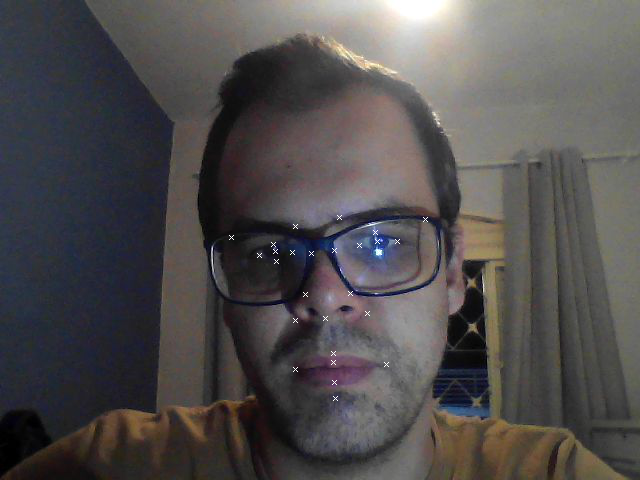

In [ ]:
# Exibindo pontos fiduciais
 
print('######### Captação dos pontos fiduciais: #########')
img = Image.open(imagefile)
draw = ImageDraw.Draw(img)
drawCrossesOnFace(detected_faces[0].face_landmarks, size=2, color='white')
img

### Análise da Concessão de Crédito - Predição no GCP

In [ ]:
# mapeamento dos valores para padrão do modelo treinado
mapa_etnia = {'Selecionar etnia':'Selecionar etnia',
              "Etnia01":0, 
              "Etnia02":1}
mapa_sexo = {'Feminino':0,
             'Masculino':1}
mapa_casapropria = {'Nao':0,
                    'Sim':1}
mapa_outrasrendas = {'Nao':0,
                     'Sim':1}
mapa_estadocivil = {'Estado01':0,
                    'Estado02':1}
etnia = mapa_etnia[etnia]
genero = mapa_sexo[genero]
casa_propria = mapa_casapropria[casa_propria]
outras_rendas = mapa_outrasrendas[outras_rendas]
estado_civil = mapa_estadocivil[estado_civil]

In [ ]:
# prepara o conteúdo e define o tipo de chamada adequado,
# dependendo de ter ou não ter a variável 'etnia' definida
if etnia != 'Selecionar etnia':
  conteudo = {"renda":{str(id_chamada):renda},
              "idade":{str(id_chamada):idade},
              "etnia":{str(id_chamada):etnia},
              "sexo":{str(id_chamada):genero},
              "casapropria":{str(id_chamada):casa_propria},
              "outrasrendas":{str(id_chamada):outras_rendas},
              "estadocivil":{str(id_chamada):estado_civil},
              "escolaridade":{str(id_chamada):escolaridade}}
  tipo_modelo = 'modelo01' 
else:
  conteudo = {"renda":{str(id_chamada):renda},
              "idade":{str(id_chamada):idade},
              "sexo":{str(id_chamada):genero},
              "casapropria":{str(id_chamada):casa_propria},
              "outrasrendas":{str(id_chamada):outras_rendas},
              "estadocivil":{str(id_chamada):estado_civil},
              "escolaridade":{str(id_chamada):escolaridade}} 
  tipo_modelo = 'modelo02'

# converte o conteúdo para o formato adequado
conteudo = pd.DataFrame(conteudo).to_json()

In [ ]:
# faz a chamada da predição e armazena a resposta na variavel default ('calote')
analyse_credit = requests.request("POST", url + "?model="+tipo_modelo, headers=headers, data=conteudo)
default = json.loads(analyse_credit.text.encode('utf8').decode())

# Caso o resultado da predição seja 0, não é provável
# que o cliente dê calote, e portanto o credito é aprovado.
# Caso contrário, o crédito é reprovado!
if default['prediction'][0] == 0:
  print('### Crédito APROVADO pela análise interna! ###')
else:
  print('### Crédito REPROVADO pela análise interna! ###')

### Crédito APROVADO pela análise interna! ###
